In [1]:
import numpy as np
import matplotlib.pyplot as plt

from normalizing_flow_utils import calc_dkl, calc_logMSE, calc_MSE, train_model

#!pip install github.com/rikab/rikabplotlib.git
from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline, function_with_band



TORCH VERSION: 2.4.0+cu121
TORCH DEVICE: cpu


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
# Physics Params
E0 = 500            # Energy of Hard Process
Lambda_QCD = 0.2    # Lambda QCD
cutoff = 0.01      # Cutoff for minimum lambda, ~ LambdaQCD / E0
R = 0.4             # Jet Radius

# Training Params
num_epochs = 2500
lr = .01
batch_size = 512
num_points = 10 # we define a prior on each point along the horizontal axis
                # eventually this should be made large

In [3]:
import torch

# TODO: Need to write a grad preserving numpy-to-torch converter for these functions

def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_) * Theta(lambda_))

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) * Theta(1 - lambda_) * Theta(lambda_))


In [4]:
# Loss functions
# 3 defaults in the normalizing_flow_utils module: calc_dkl, calc_logMSE, calc_MSE


def counting_parameter(x, C = 1):
    return C * alpha_s(E0 * x) * torch.log(1/x) / x 

def calc_dkl(logp, logq, x = None):
    print("logp", logp)
    print("logq", logq)
    return torch.sum((logp - logq))

def batch_MSE(logp, logq, x = None):


    p = torch.exp(logp)
    q = torch.exp(logq)

    # We want p and q to agree up to O(counting_parameter^2)
    allowed_error = counting_parameter(x)**2

    return torch.nanmean((p - q)**2 / allowed_error**2 / 2) / (10)**4 


def batch_logMSE(logp, logq, x = None):


    # We want p and q to agree up to O(counting_parameter^2)
    allowed_error =  counting_parameter(x)**2

    return torch.nanmean((logp - logq)**2 / (allowed_error)**2 / 2) / (10)**4


losses_dict = {
    "DKL": calc_dkl,
    "MSE": calc_MSE,
    "logMSE": calc_logMSE,
    "batch_MSE": batch_MSE,
    "batch_logMSE": batch_logMSE
}


100%|██████████| 2500/2500 [02:03<00:00, 20.29it/s]


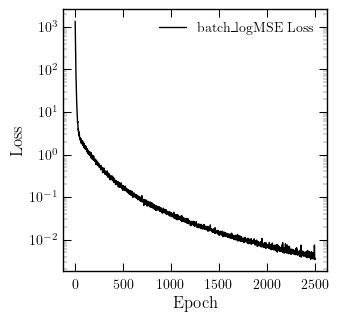

In [5]:

my_loss = "batch_logMSE"



# TODO: Weird issue, have to run exactly once before it works the second time time
model, losses = train_model(LO_angularity, losses_dict[my_loss], 2500, num_points, batch_size, lr  )

fig, ax = newplot("column")
ax.plot(losses, label=f"{my_loss} Loss", color = "black")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.yscale("log")

In [6]:
print(losses)

[array(1347.10319254), array(917.90984836), array(649.26910666), array(455.88608214), array(301.84679234), array(205.45538721), array(153.96906154), array(114.05263747), array(86.63233799), array(62.53794206), array(55.50617355), array(42.54823508), array(36.70456221), array(27.41065524), array(23.69445109), array(19.66166347), array(15.6643761), array(14.32244557), array(12.89637057), array(11.41709027), array(10.25013109), array(7.9768039), array(7.91905239), array(7.19445458), array(6.16860585), array(5.63316234), array(6.03191348), array(5.47816016), array(5.09756864), array(4.64036174), array(4.46518488), array(4.20839229), array(3.82826335), array(4.0182875), array(3.4550223), array(3.53956244), array(3.54220406), array(3.40435365), array(3.42047711), array(3.05675667), array(3.33114725), array(3.15075704), array(2.9577488), array(2.68571097), array(2.91204643), array(2.67965051), array(2.50272025), array(2.51509659), array(2.34755016), array(2.49292012), array(2.21360547), array

In [7]:
# from normalizing_flow_utils import SimpleNormal, grab
# from scipy.optimize import curve_fit


# samples = 1000

# if torch.cuda.is_available():
#     torch_device = 'cuda'
#     float_dtype = np.float32 # single
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)
# else:
#     torch_device = 'cpu'
#     float_dtype = np.float64 # double
#     torch.set_default_tensor_type(torch.DoubleTensor)
#     print(f"TORCH DEVICE: {torch_device}")

# def fixed_order_expansion(x, *params):

#     expansion_parameter = alpha_s(E0 * x) * torch.log(1/x) / x
#     fixed_order = np.sum([params[i] * expansion_parameter**i / np.math.factorial(i) for i in range(len(params))], axis = 0)

#     return fixed_order


# prior = SimpleNormal(torch.zeros(samples), torch.ones(samples))
# z = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)    
# x, logJ = model(z)
# logJ = logJ.reshape(batch_size, samples)
# x = grab(x)

# logq = prior.log_prob(z) - logJ
# y = np.exp(grab(logq))

# # Fit the data to the fixed order expansion
# N = 2
# initial_params = np.ones(N + 1)

# popt, pcov = curve_fit(fixed_order_expansion, x, y, p0 = initial_params)

# print(popt)
    

TORCH DEVICE: cpu
integral tensor(0.8215)
integral tensor(16.3400)


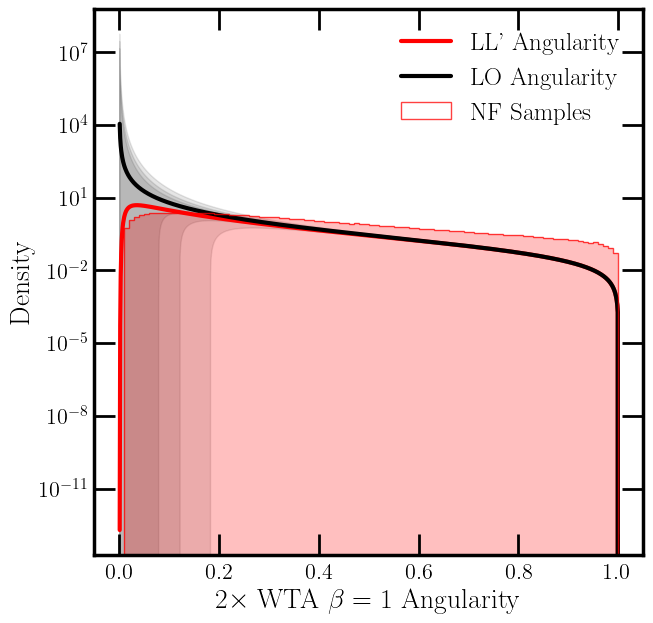

In [8]:
from normalizing_flow_utils import SimpleNormal, grab
from scipy.optimize import curve_fit


if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
    print(f"TORCH DEVICE: {torch_device}")

# Plot details
fig, ax = newplot("full")
plt.yscale("log")
plt.xlabel(r"$2 \times $ WTA $\beta = 1$ Angularity")
plt.ylabel("Density")
samples = 1000


# Leading Log Angularity
x_test = torch.linspace(0.001, 1, samples)
y_test = LL_angularity(x_test)
print("integral", torch.trapz(y_test, x_test))
ax.plot(x_test, y_test, label="LL' Angularity", color = "red")

# Leading Order Angularity
x_test = torch.linspace(0.001, 1, samples)
y_test = LO_angularity(x_test)
print("integral", torch.trapz(y_test, x_test))
ax.plot(x_test, y_test, label="LO Angularity", color = "black")

# Band around the Leading Order Angularity
allowed_error_half = counting_parameter(x_test, C = np.sqrt(0.5))**2
allowed_error = counting_parameter(x_test)**2
allowed_error2 = counting_parameter(x_test, C = np.sqrt(2))**2
ax.fill_between(x_test, y_test - allowed_error_half, y_test + allowed_error_half, alpha = 0.1, color = "black")
ax.fill_between(x_test, y_test - allowed_error, y_test + allowed_error, alpha = 0.1, color = "black")
ax.fill_between(x_test, y_test - allowed_error2, y_test + allowed_error2, alpha = 0.1, color = "black")

# Normalizing Flow -- samples
prior = SimpleNormal(torch.zeros(samples), torch.ones(samples))
z = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)    
x, logJ = model(z)
x = grab(x)
hist_with_outline(ax, x / np.max(x), bins=100, range=(0,1), label="NF Samples", color = "red", density = True)

# # Fixed Order Expansion
# ax.plot(x_test, fixed_order_expansion(x_test, *popt), label="Fixed Order Expansion", color = "blue")



# # Normalizing Flow -- density
# logq = prior.log_prob(z)
# logJ = logJ.reshape(batch_size, samples)
# logp = logq - logJ
# p = torch.exp(logp)
# p = grab(p)
# plt.plot(x, p.flatten(), label="NF Density", color = "red")

plt.legend(loc = 'upper right')

